In [1]:
from lattice.ensemble import Ensemble
from lattice.protein_config import ProteinConfig
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from itertools import product
from concurrent.futures import ProcessPoolExecutor
import os
from collections import defaultdict, Counter
import time
from IPython.display import clear_output

In [41]:
proteins = ['HHHHHHHHHH', 'HPHPPHPPHH', 'HPPHPPHPHH', 'PPPPPPHPPH', 'PPPPPHHHHH', 'PPPPPPPPPP']
ensembles = [Ensemble(protein) for protein in proteins]

def generate_sequences():
    sequences = [''.join(p) for p in product("HP", repeat=10)]
    sequences.sort(key=lambda s: (-s.count('H'), s))
    return sequences

def generate_all_ensembles_parallel(max_workers=None):
    sequences = generate_sequences()

    if max_workers is None:
        max_workers = os.cpu_count()

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        all_ensembles = list(executor.map(Ensemble, sequences))

    return all_ensembles

all_ensembles = generate_all_ensembles_parallel()
rows = []

for ens in all_ensembles:
    rows.append({
        "protein_string": ens.protein_string,
        "phi": ens.phi,
        "s_max_HH": ens.s_max_HH,
        "p_avg_compactness_ns": ens.p_average_compactness_native_state,
        "g_degeneracy_smaxHH": ens.g_degeneracy(ens.s_max_HH),
        "ensemble_size": len(ens.ensemble),
        "x_avg_core_dist_ns": ens.x_average_core_distribution_native_state,
    })

df = pd.DataFrame(rows)

In [42]:
df

,protein_string,phi,s_max_HH,p_avg_compactness_ns,g_degeneracy_smaxHH,ensemble_size,x_avg_core_dist_ns
0,HHHHHHHHHH,1.0,4,1.000000,98,2034,0.887755
1,HHHHHHHHHP,0.9,4,1.000000,8,2034,1.000000
2,HHHHHHHHPH,0.9,4,1.000000,54,2034,0.870370
3,HHHHHHHPHH,0.9,4,1.000000,43,2034,0.883721
4,HHHHHHPHHH,0.9,4,1.000000,42,2034,0.928571
...,...,...,...,...,...,...,...
1019,PPPPPPHPPP,0.1,0,0.299041,2034,2034,0.020157
1020,PPPPPPPHPP,0.1,0,0.299041,2034,2034,0.009587
1021,PPPPPPPPHP,0.1,0,0.299041,2034,2034,0.008604
1022,PPPPPPPPPH,0.1,0,0.299041,2034,2034,0.004425


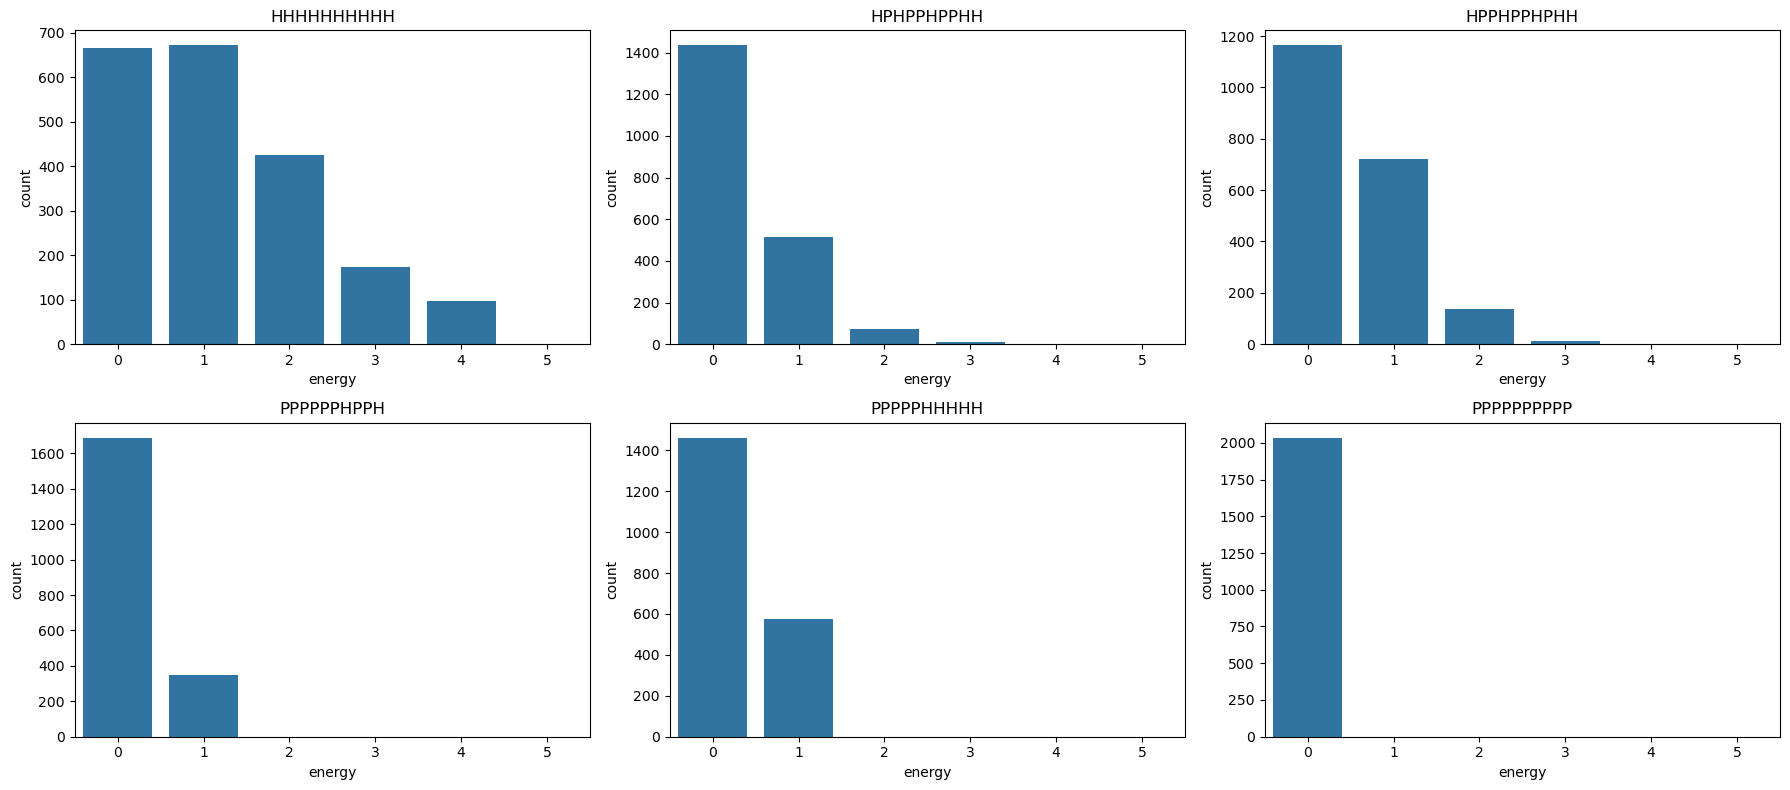

In [4]:
################
### Figure 2 ###
################

n = len(ensembles)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, ens in zip(axes, ensembles):
    sns.barplot(data=ens.degeneracies_df, x="count", y="energy", ax=ax)
    ax.set_title(ens.protein_string)
    ax.set_xlabel("energy")
    ax.set_ylabel("count")
    
plt.tight_layout()
plt.show()

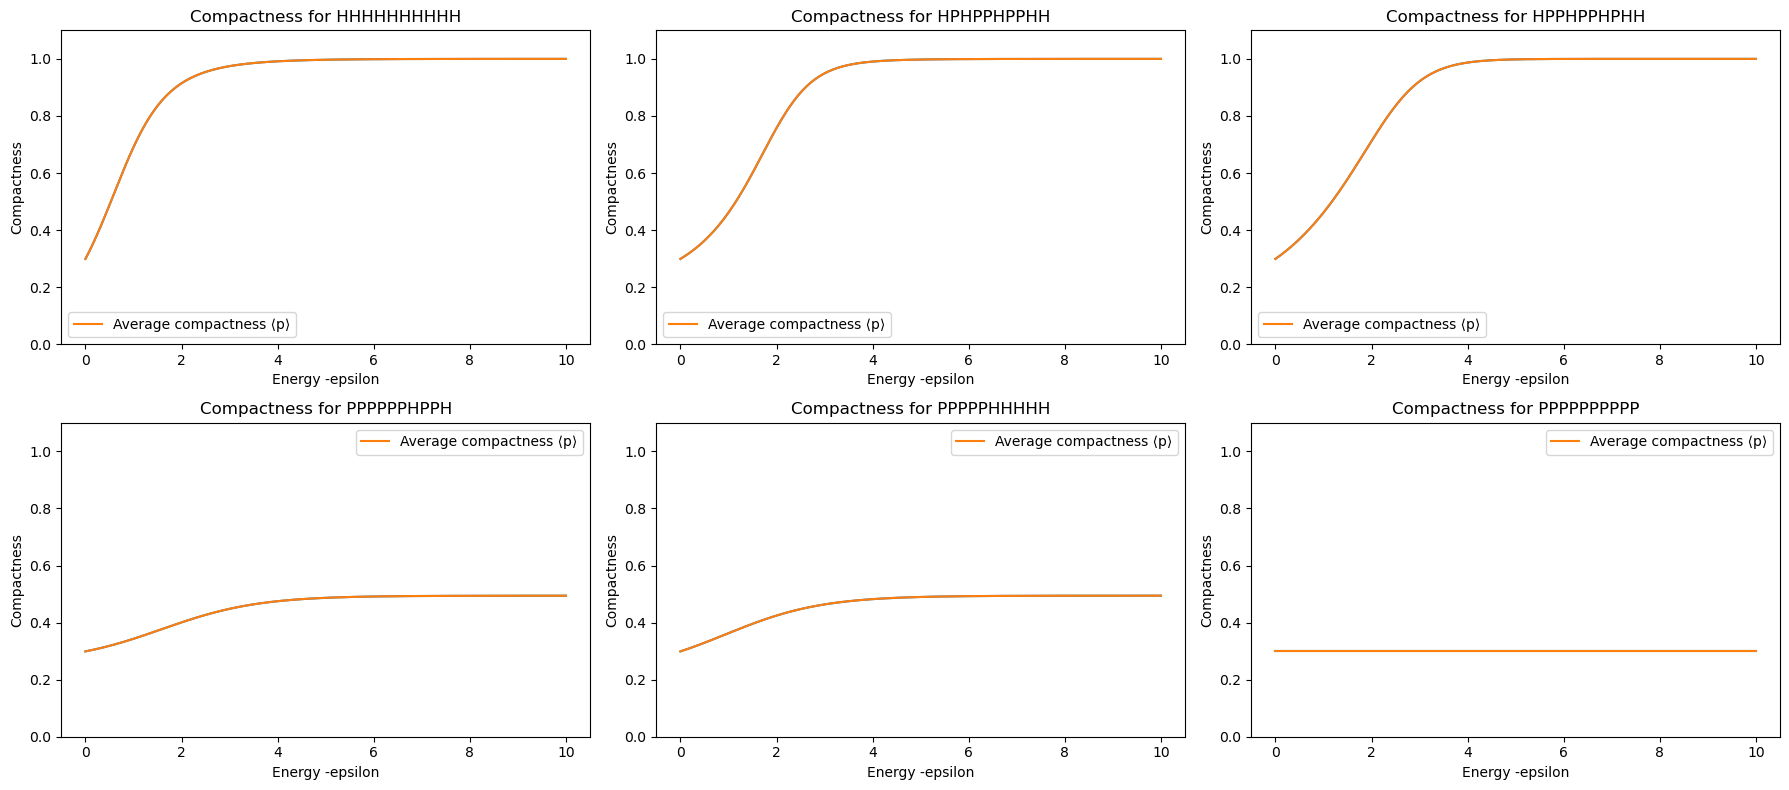

In [46]:
################
### Figure 3 ###
################

n = len(ensembles)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, ens in zip(axes, ensembles):
    L = len(ens.protein_string)
    xs = np.linspace(0, L, 300)

    ys = [ens.p_average_compactness(-x) for x in xs]
    #ys_max = [ens.p_maximum_term(-x) for x in xs]

    ax.plot(xs, ys)
    #ax.plot(xs, ys_max)
    ax.plot(xs, ys, label="Average compactness ⟨p⟩")
    #ax.plot(xs, ys_max, label="Maximum-term compactness p*")
    
    ax.set_xlabel("Energy -epsilon")
    ax.set_ylabel("Compactness")
    ax.set_title(f"Compactness for {ens.protein_string}")
    ax.set_ylim(top=1.1, bottom=0)
    ax.legend()  # ← Add legend for this subplot

plt.tight_layout()
plt.show()

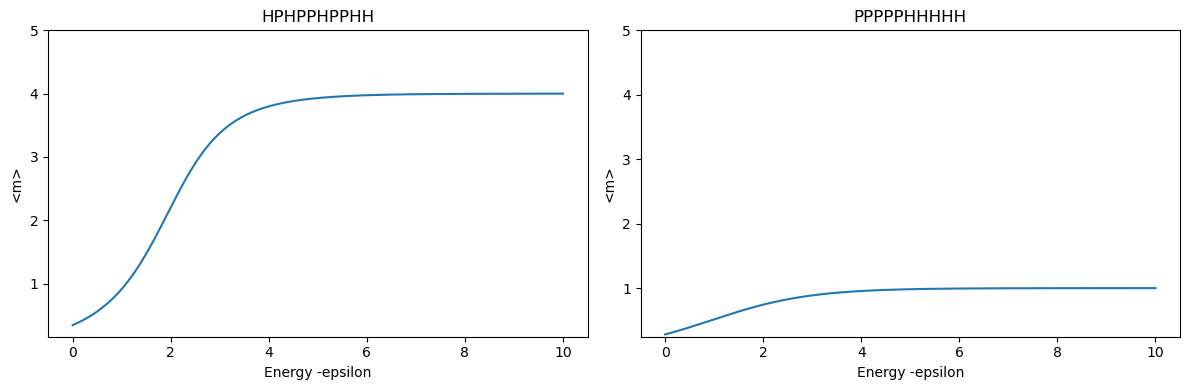

In [6]:
###################
### FIgure 4a,e ###
###################

n = len(ensembles)
cols = 2
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, ens in zip(axes, [ensembles[1], ensembles[4]]):
    L = len(ens.protein_string)
    xs = np.linspace(0, L, 300)

    ys = [ens.m_average_molecule_energy(-x) for x in xs]

    ax.plot(xs, ys)
    
    ax.set_xlabel("Energy -epsilon")
    ax.set_ylabel("<m>")
    ax.set_title(f"{ens.protein_string}")
    ax.set_ylim(top=5)

plt.tight_layout()
plt.show()

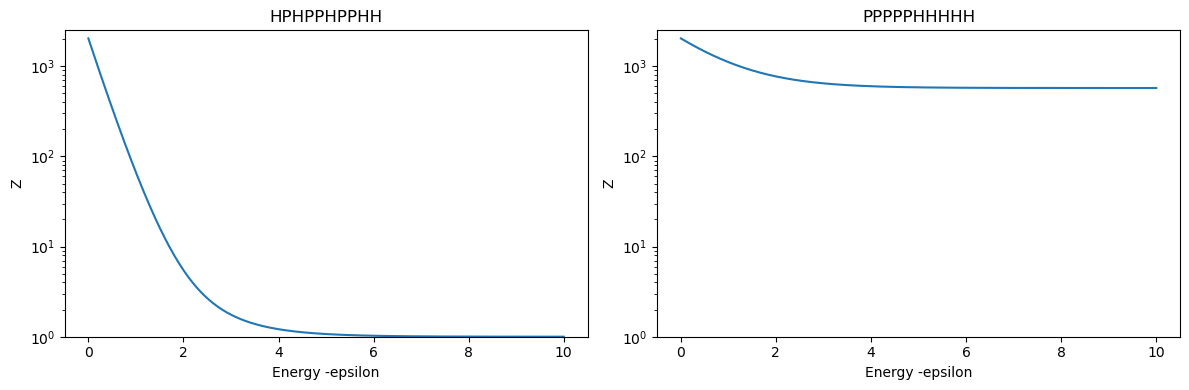

In [7]:
###################
### FIgure 4b,f ###
###################

n = len(ensembles)
cols = 2
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, ens in zip(axes, [ensembles[1], ensembles[4]]):
    L = len(ens.protein_string)
    xs = np.linspace(0, L, 300)

    ys = [ens.z_partition_function(epsilon=-x) for x in xs]

    ax.plot(xs, ys)
    ax.set_yscale("log")
    ax.set_xlabel("Energy -epsilon")
    ax.set_ylabel("Z")
    ax.set_title(f"{ens.protein_string}")
    ax.set_ylim(bottom=1, top=2500)

plt.tight_layout()
plt.show()

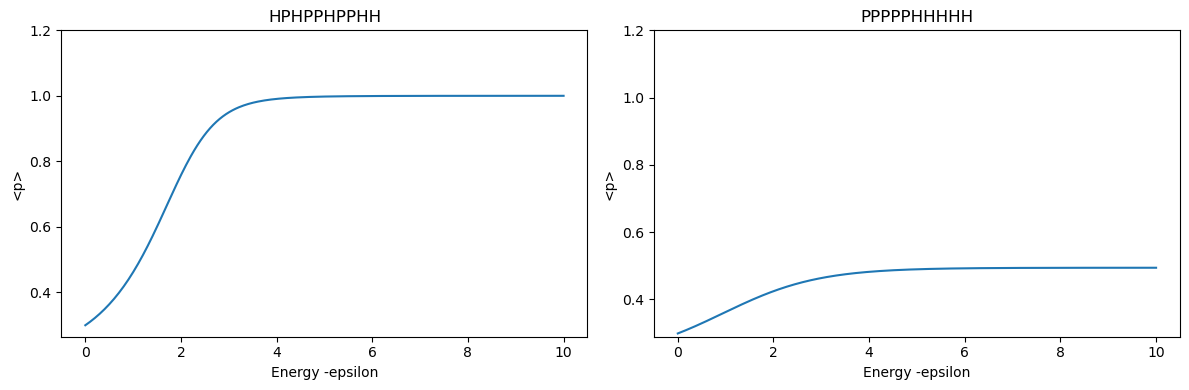

In [8]:
###################
### FIgure 4c,g ###
###################

n = len(ensembles)
cols = 2
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, ens in zip(axes, [ensembles[1], ensembles[4]]):
    L = len(ens.protein_string)
    xs = np.linspace(0, L, 300)

    ys = [ens.p_average_compactness(-x) for x in xs]

    ax.plot(xs, ys)
    
    ax.set_xlabel("Energy -epsilon")
    ax.set_ylabel("<p>")
    ax.set_title(f"{ens.protein_string}")
    ax.set_ylim(top=1.2)

plt.tight_layout()
plt.show()

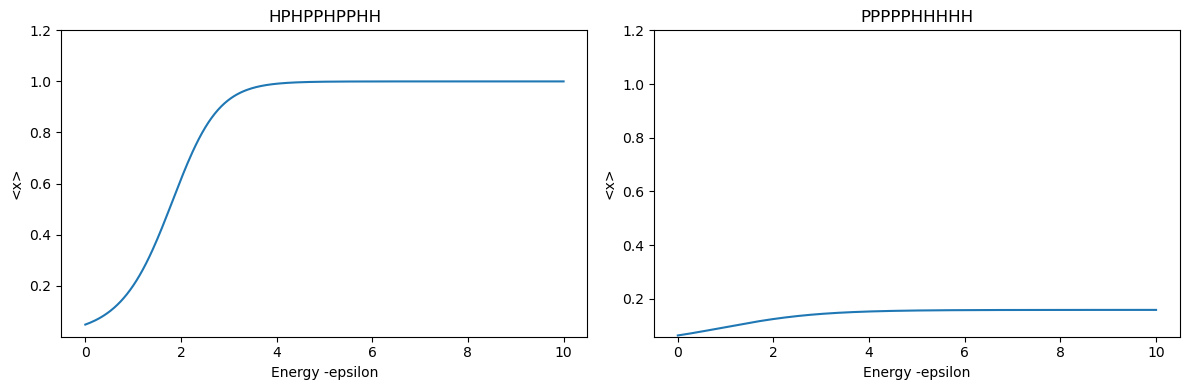

In [9]:
###################
### FIgure 4d,h ###
###################

n = len(ensembles)
cols = 2
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, ens in zip(axes, [ensembles[1], ensembles[4]]):
    L = len(ens.protein_string)
    xs = np.linspace(0, L, 300)

    ys = [ens.x_average_core_distribution(-x) for x in xs]

    ax.plot(xs, ys)
    
    ax.set_xlabel("Energy -epsilon")
    ax.set_ylabel("<x>")
    ax.set_title(f"{ens.protein_string}")
    ax.set_ylim(top=1.2)

plt.tight_layout()
plt.show()

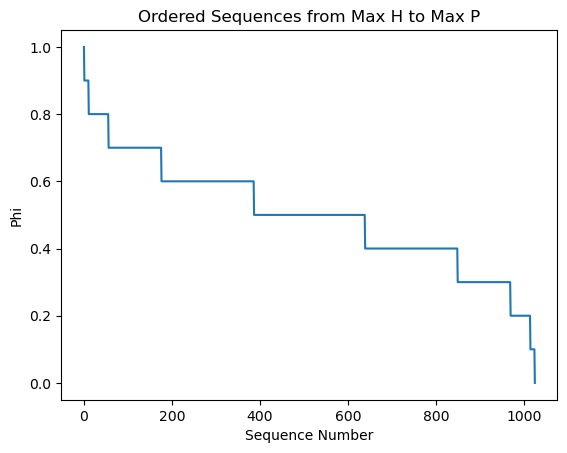

In [10]:
################
### FIgure 5 ###
################

fig, ax = plt.subplots()

xs = np.linspace(0, len(all_ensembles), len(all_ensembles))
ys = [ensemble.phi for ensemble in all_ensembles]

ax.plot(xs, ys)
ax.set_xlabel("Sequence Number")
ax.set_ylabel("Phi")
ax.set_title("Ordered Sequences from Max H to Max P")

plt.show()

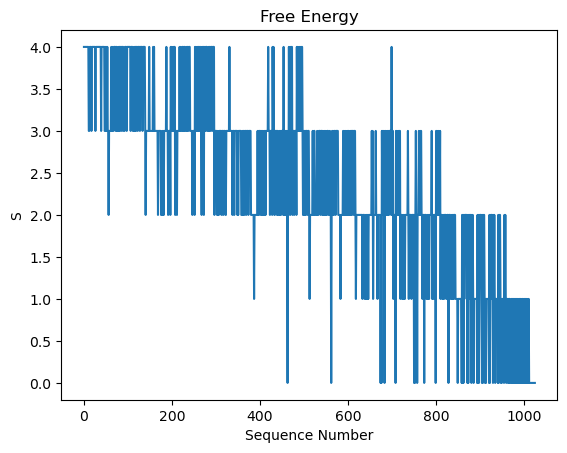

In [11]:
#################
### FIgure 6a ###
#################

fig, ax = plt.subplots()

xs = np.linspace(0, len(all_ensembles), len(all_ensembles))
ys = [ensemble.s_max_HH for ensemble in all_ensembles]

ax.plot(xs, ys)
ax.set_xlabel("Sequence Number")
ax.set_ylabel("S")
ax.set_title("Free Energy")

plt.show()

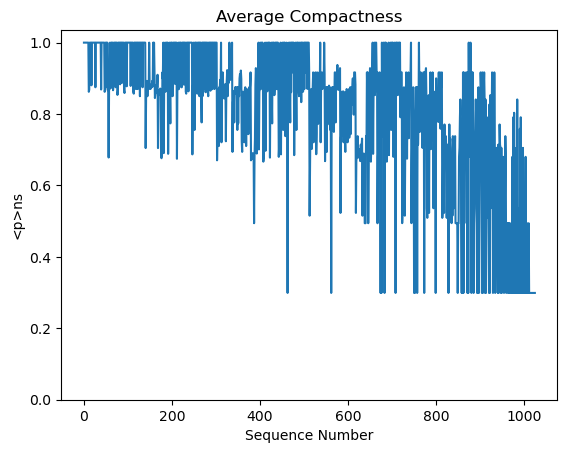

In [12]:
#################
### FIgure 6b ###
#################

fig, ax = plt.subplots()

xs = np.linspace(0, len(all_ensembles), len(all_ensembles))
ys = [ensemble.p_average_compactness_native_state for ensemble in all_ensembles]

ax.plot(xs, ys)
ax.set_xlabel("Sequence Number")
ax.set_ylabel("<p>ns")
ax.set_ylim(bottom=0)
ax.set_title("Average Compactness")


plt.show()

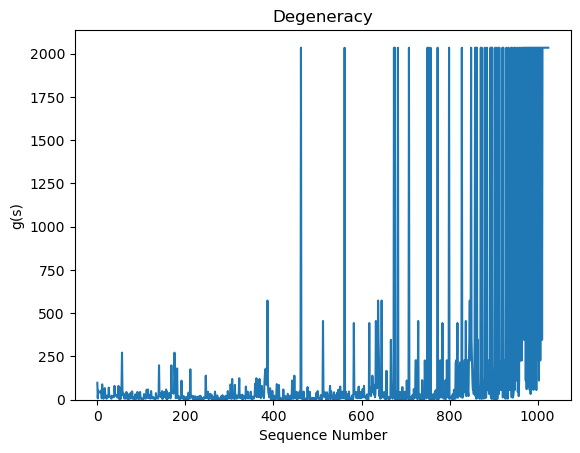

In [13]:
#################
### FIgure 6c ###
#################
# compute the degeneracy 

fig, ax = plt.subplots()

xs = np.linspace(0, len(all_ensembles), len(all_ensembles))
ys = [ensemble.g_degeneracy(ensemble.s_max_HH) for ensemble in all_ensembles]

ax.plot(xs, ys)
ax.set_xlabel("Sequence Number")
ax.set_ylabel("g(s)")
ax.set_ylim(bottom=0)
ax.set_title("Degeneracy")

plt.show()

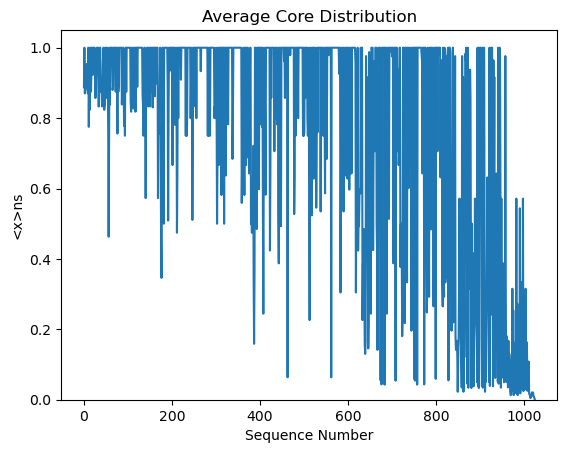

In [14]:
#################
### FIgure 6d ###
#################

fig, ax = plt.subplots()

xs = np.linspace(0, len(all_ensembles), len(all_ensembles))
ys = [ensemble.x_average_core_distribution_native_state for ensemble in all_ensembles]

ax.plot(xs, ys)
ax.set_xlabel("Sequence Number")
ax.set_ylabel("<x>ns")
ax.set_ylim(bottom=0)
ax.set_title("Average Core Distribution")

plt.show()

In [15]:
ensemble_dict = defaultdict(list)

for ensemble in all_ensembles:
    ensemble_dict[ensemble.phi].append(ensemble)

phis = []
ensembles = []

for phi, ens_list in ensemble_dict.items():
    phis.append(phi)
    ensembles.append(ens_list)

phis.reverse()
ensembles.reverse()

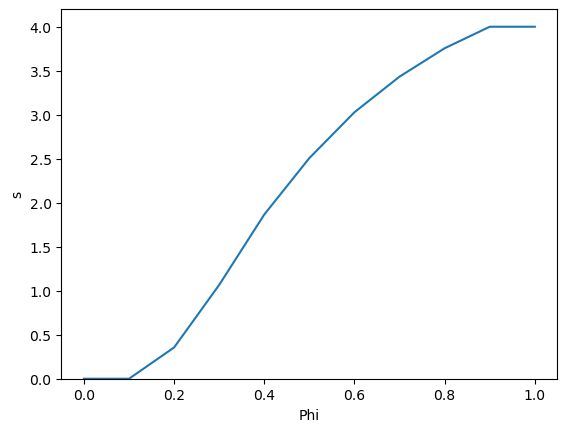

In [16]:
#################
### FIgure 7a ###
#################

fig, ax = plt.subplots()

grouped = df.groupby("phi")["s_max_HH"].mean()
phis = grouped.index.values
ys = grouped.values

ax.plot(phis, ys)

ax.set_xlabel("Phi")
ax.set_ylabel("s")
ax.set_ylim(bottom=0)

plt.show()

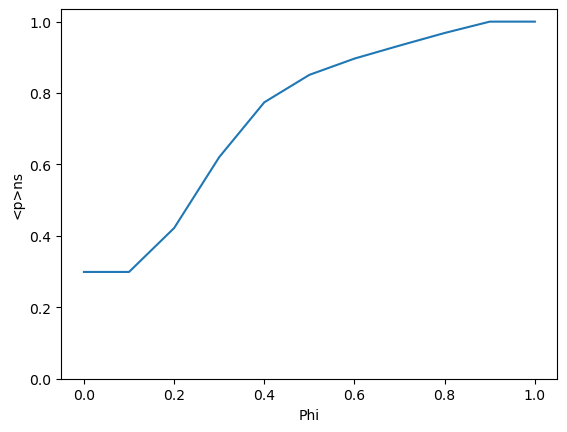

In [17]:
#################
### FIgure 7b ###
#################

fig, ax = plt.subplots()

grouped = df.groupby("phi")["p_avg_compactness_ns"].mean()
phis = grouped.index.values
ys = grouped.values

ax.plot(phis, ys)
ax.set_xlabel("Phi")
ax.set_ylabel("<p>ns")
ax.set_ylim(bottom=0)

plt.show()

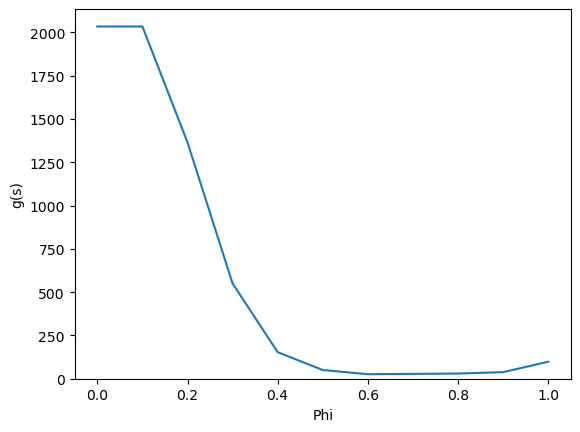

In [18]:
#################
### FIgure 7c ###
#################

fig, ax = plt.subplots()

grouped = df.groupby("phi")["g_degeneracy_smaxHH"].mean()

phis = grouped.index.values
ys = grouped.values

ax.plot(phis, ys)
ax.set_xlabel("Phi")
ax.set_ylabel("g(s)")
ax.set_ylim(bottom=0)

plt.show()


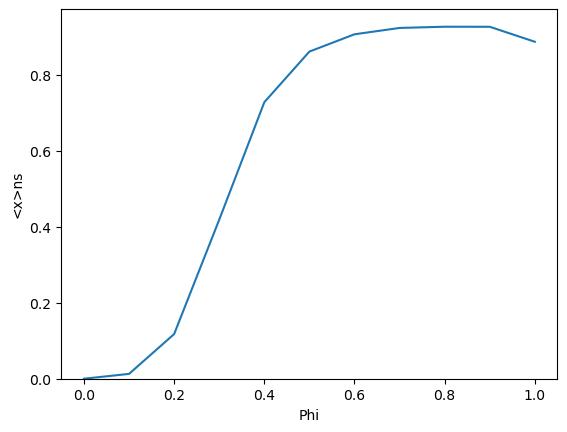

In [19]:
#################
### FIgure 7d ###
#################
## TODO this doesnt match the paper for some reason

fig, ax = plt.subplots()

# Mean <x>_ns for each phi
grouped = df.groupby("phi")["x_avg_core_dist_ns"].mean()

phis = grouped.index.values
ys = grouped.values

ax.plot(phis, ys)
ax.set_xlabel("Phi")
ax.set_ylabel("<x>ns")
ax.set_ylim(bottom=0)

plt.show()

In [20]:
df

,protein_string,phi,s_max_HH,p_avg_compactness_ns,g_degeneracy_smaxHH,x_avg_core_dist_ns
0,HHHHHHHHHH,1.0,4,1.000000,98,0.887755
1,HHHHHHHHHP,0.9,4,1.000000,8,1.000000
2,HHHHHHHHPH,0.9,4,1.000000,54,0.870370
3,HHHHHHHPHH,0.9,4,1.000000,43,0.883721
4,HHHHHHPHHH,0.9,4,1.000000,42,0.928571
...,...,...,...,...,...,...
1019,PPPPPPHPPP,0.1,0,0.299041,2034,0.020157
1020,PPPPPPPHPP,0.1,0,0.299041,2034,0.009587
1021,PPPPPPPPHP,0.1,0,0.299041,2034,0.008604
1022,PPPPPPPPPH,0.1,0,0.299041,2034,0.004425


In [21]:
def plot_binned_distribution(df, column, start, end, num_bins):
    # Extract values
    values = df[column].values

    # Create bins
    bins = np.linspace(start, end, num_bins + 1)

    # Digitize values into bins
    bin_indices = np.digitize(values, bins, right=False)

    # Count how many fall into each bin
    counts = [(bin_indices == i).sum() for i in range(1, num_bins + 1)]
    print(counts)

    # Compute bar positions (midpoints of bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(bin_centers, counts, width=(bins[1] - bins[0]) * 0.9)

    plt.xlabel(column)
    plt.ylabel("Count")
    plt.title(f"Distribution of {column} (binned)")
    plt.tight_layout()
    plt.show()

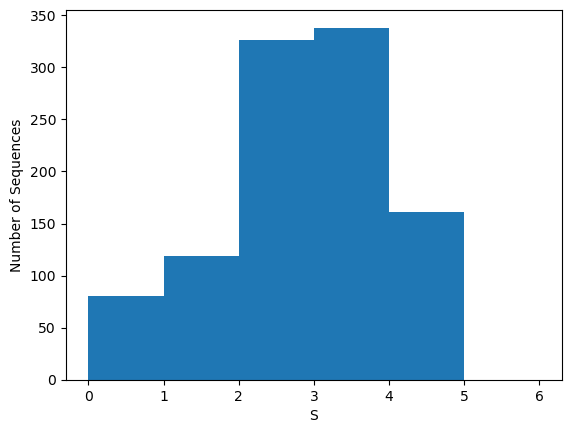

In [22]:
#################
### FIgure 8a ###
#################

plt.hist(df["s_max_HH"], bins=range(0, 7, 1))
plt.xlabel("S")
plt.ylabel("Number of Sequences")
plt.show()

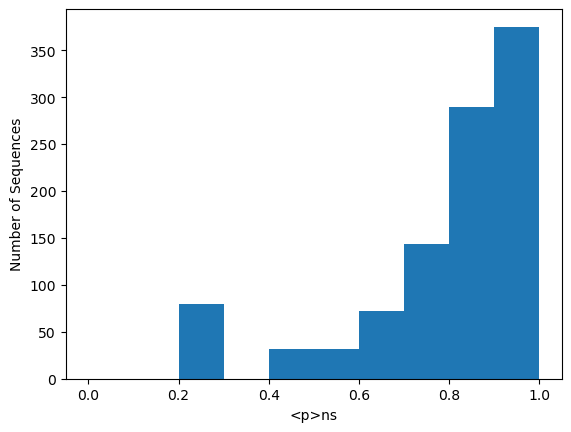

In [23]:
#################
### FIgure 8b ###
#################
## TODO i think this has some issues

plt.hist(df["p_avg_compactness_ns"], bins=np.arange(0, 1.1, 0.1))
plt.xlabel("<p>ns")
plt.ylabel("Number of Sequences")
plt.show()

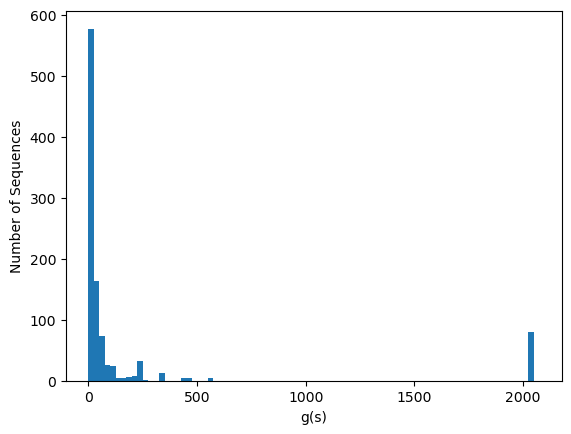

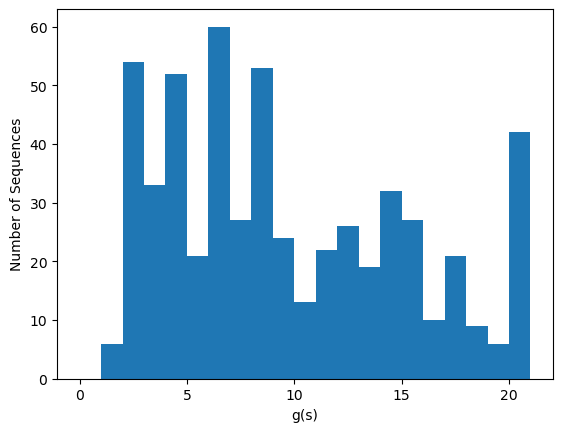

In [24]:
#################
### FIgure 8c ###
#################

plt.hist(df["g_degeneracy_smaxHH"], bins=np.arange(0, 2100, 25))
plt.xlabel("g(s)")
plt.ylabel("Number of Sequences")
plt.show()

plt.hist(df["g_degeneracy_smaxHH"], bins=np.arange(0, 22, 1))
plt.xlabel("g(s)")
plt.ylabel("Number of Sequences")
plt.show()

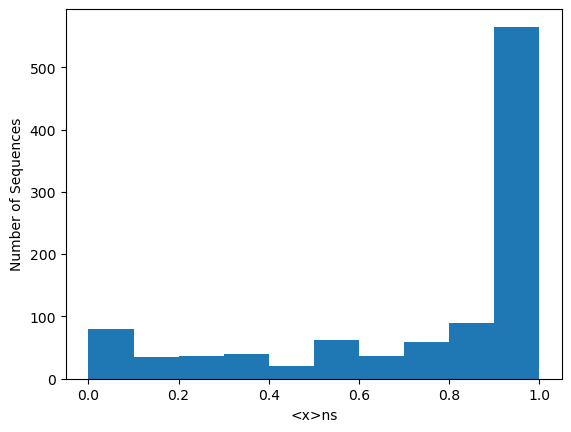

In [25]:
#################
### FIgure 8d ###
#################

plt.hist(df["x_avg_core_dist_ns"], bins=np.arange(0.0, 1.1, 0.1))
plt.xlabel("<x>ns")
plt.ylabel("Number of Sequences")
plt.show()

In [26]:
count = 0
for ensemble in all_ensembles:
    degens = ensemble.degeneracies
    if degens[ensemble.s_max_HH] == 1:
        count += 1

print(count)

6


In [28]:
protein = 'PPP'
value_dict = {}
for _ in range(0, 12):
    ensemble = Ensemble(protein)
    value_dict[len(protein)] = len(ensemble.ensemble)
    protein += 'P'

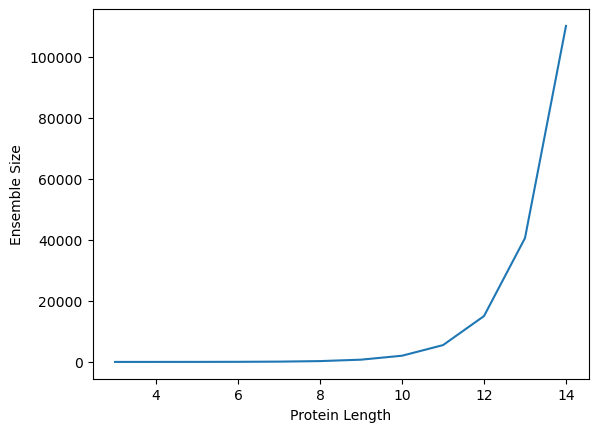

In [29]:
rows = []

for key, value in value_dict.items():
    rows.append({
        "length": key,
        "ensemble_size": value,
    })

ensemble_size = pd.DataFrame(rows)


fig, ax = plt.subplots()

ax.plot(ensemble_size['length'], ensemble_size['ensemble_size'])
ax.set_xlabel("Protein Length")
ax.set_ylabel("Ensemble Size")

plt.show()

In [48]:
protein = ProteinConfig.from_string('HHHHHPPHHHHPPHPHHHHPPHPHPHPHHHHHPPPPHPHPHHPHHHPPH')

for i in range(200):
    print(protein.contacts)
    print(protein)
    protein.fold()
    time.sleep(.1)
    clear_output(wait=True)

HH: 0
HP: 3
PP: 1
.   .   .   .   .   .   .   .   .   .   .   .   .   .   H - H   .   .   .   .
                                                        |                    
.   .   .   .   .   .   .   .   .   .   .   .   .   .   H   .   .   .   .   .
                                                        |                    
.   .   .   .   .   .   .   .   .   .   .   .   .   .   H - H   .   .   .   .
                                                            |                
.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   P - P   .   .   .
                                                                |            
.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   H   .   .   .
                                                                |            
.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   H - H   .   .
                                                                    |        
.   .   .   .   .   .   .   P - P - P   .   H 